In [561]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

#config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [562]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax

from jax.scipy.special import gammaln

import mrcfile

plt.rcParams["figure.figsize"]=6,6

In [563]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))


In [835]:
K = 2
N = 100
sigma = 0.01

alpha = jnp.array([10,10])

In [836]:
key, subkey = random.split(key)
pi = random.dirichlet(subkey, alpha)
print(pi)
print(jnp.sum(pi))

[0.46062138 0.53937862]
0.9999999999999999


In [837]:
key, subkey = random.split(key)
z = random.categorical(subkey, jnp.log(pi), shape = (N,))
print(jnp.sum(z==0)/N)
print(jnp.sum(z==1)/N)

0.51
0.49


In [838]:
key, subkey = random.split(key)
x = random.normal(subkey, shape = (K,))
print(x)
#print(y.shape)

[-1.04175224  1.39043824]


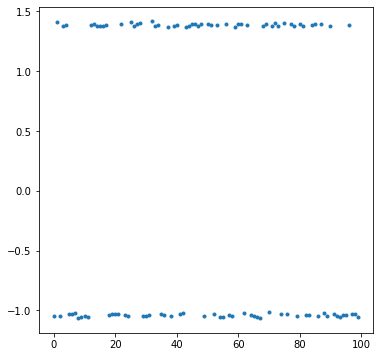

In [839]:
key, subkey = random.split(key)
y = x[z] + sigma * random.normal(subkey, shape = (N,))
plt.plot(y, '.')

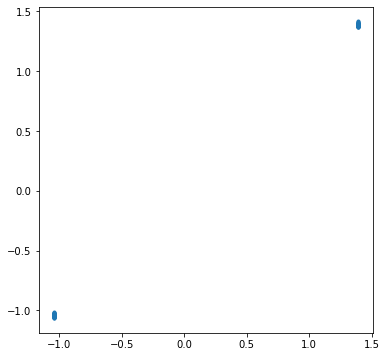

In [840]:
plt.plot(x[z], y, '.')

In [841]:
def calc_nik_ki(z,k,i): 
    z = z.at[i].set(jnp.inf)    
    return jnp.sum(z == k)

calc_nik_i = lambda z, i : jax.vmap(calc_nik_ki, in_axes = (None, 0, None))(z, jnp.arange(K), i)
calc_nik = lambda z : jax.vmap(calc_ik_i, in_axes = (None, 0))(z, jnp.arange(N))
calc_nik_jit = jax.jit(calc_nki)

calc_nk_k = lambda z, k : jnp.sum(z == k)
calc_nk = lambda z : jax.vmap(calc_nk_k, in_axes = (None, 0))(z, jnp.arange(K))
calc_nk_jit = jax.jit(calc_nk)

In [842]:
nki_jit(z).shape

(100, 2)

In [843]:
print(calc_nik_ki(z, 0, 13))
print(calc_nik_ki(z, 1, 13))
print(calc_nik_ki(z, 2, 13))

51
48
0


In [844]:
calc_nik_jit(z).shape

(100, 2)

In [845]:
calc_nk_jit(z)

DeviceArray([51, 49], dtype=int64)

In [846]:
def logPi(x, z, y, sigma, alpha):
    n_ik = calc_nki_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)
    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha))

    # TODO: vectorize
    for k in jnp.arange(K):
        log_arg += jnp.exp(jnp.exp(-(y - x[k])**2/sigma))*(n_ik[:, k] + alpha[k])
        logPZalpha += gammaln(n_k[k] + alpha[k])
    
    return jnp.sum(jnp.log(log_arg)) - jnp.sum(x**2) + logPZalpha

In [847]:
@jax.jit
def proposal_x(key, x0, logPiX0, B, z, y, sigma, alpha):
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x0(key, x00, logPiX0, B, x1, z, y, sigma, alpha):
    x01 = random.uniform(key) * 2*B-B
    
    logPiX0 = logPi(jnp.array([x00, x1]), z, y, sigma, alpha)
    logPiX1 = logPi(jnp.array([x01, x1]), z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x01, r, logPiX1, logPiX0    

@jax.jit
def proposal_x1(key, x10, logPiX0, B, x0, z, y, sigma, alpha):
    x11 = random.uniform(key) * 2*B-B
    
    logPiX0 = logPi(jnp.array([x0, x10]), z, y, sigma, alpha)
    logPiX1 = logPi(jnp.array([x0, x11]), z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x11, r, logPiX1, logPiX0    

@jax.jit
def proposal_z(key, z0, logPiX0, x, y, sigma, alpha, K):
    z1 = random.randint(key, z0.shape, 0, K) 
    
    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0
     

### First, sample x

In [848]:
x

DeviceArray([-1.04175224,  1.39043824], dtype=float64)

  MCMC sample 1000, loss = 449.8853198116319, a = 4.1204628587548056e-13
  MCMC sample 2000, loss = 451.451422460294, a = 5.903112654677594e-14
  MCMC sample 3000, loss = 448.67462324861947, a = 1.5698768378626377e-15
  MCMC sample 4000, loss = 451.6466347824877, a = 2.6600804926828965e-15
  MCMC sample 5000, loss = 451.75488871080404, a = 4.7166811714908984e-14
  MCMC sample 6000, loss = 451.75537413549705, a = 1.625805309370686e-16
  MCMC sample 7000, loss = 451.7275890402369, a = 0.0007684851716919817
  MCMC sample 8000, loss = 451.76659266703473, a = 1.2424204052268001e-17
  MCMC sample 9000, loss = 451.37634535319125, a = 8.442560831514964e-14
  MCMC sample 10000, loss = 450.4320929564112, a = 1.4753654418724556e-14
0.18909278385048278
-1.058753711227347
[-1.04175224  1.39043824]


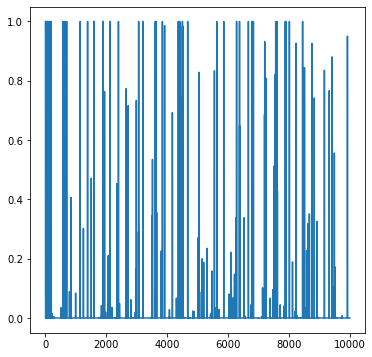

In [849]:
N_samples_x = 10001
#x0 = jnp.array(np.random.randn(K))
x0 = jnp.array(np.random.rand())
B = 3

#params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}
params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "x1" : x[1]}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x0, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)

print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)

  MCMC sample 1000, loss = 451.4982912926115, a = 1.284448445445355e-08
  MCMC sample 2000, loss = 451.64416735626673, a = 1.3075687374523254e-12
  MCMC sample 3000, loss = 451.5865113939626, a = 3.582640303276263e-14
  MCMC sample 4000, loss = 451.58909324303454, a = 3.022603105406367e-14
  MCMC sample 5000, loss = 451.71517095499405, a = 2.5593768974573016e-16
  MCMC sample 6000, loss = 451.75550675029945, a = 1.7366703021813483e-15
  MCMC sample 7000, loss = 451.70019459422485, a = 1.1962467068355325e-10
  MCMC sample 8000, loss = 450.40278074205673, a = 4.368984730692972e-13
  MCMC sample 9000, loss = 449.5286029188727, a = 3.011509929911639e-13
  MCMC sample 10000, loss = 450.12225622110327, a = 1.5036481307703185e-12
0.3346307492610884
1.410558616507263
[-1.04175224  1.39043824]


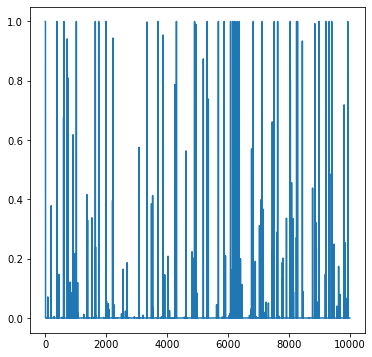

In [850]:
N_samples_x = 10001
#x0 = jnp.array(np.random.randn(K))
x0 = jnp.array(np.random.rand())
B = 3

#params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}
params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "x0" : x[0]}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x1, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)
print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)


  MCMC sample 1000, loss = 448.1899018673356, a = 3.44565468060232e-21
  MCMC sample 2000, loss = 449.3531834171687, a = 1.186459075423566e-21
  MCMC sample 3000, loss = 449.3531834171687, a = 4.564436777532618e-26
  MCMC sample 4000, loss = 449.65252121474384, a = 9.259534370371626e-15
  MCMC sample 5000, loss = 449.65252121474384, a = 7.281707665385865e-26
  MCMC sample 6000, loss = 449.65252121474384, a = 6.108358379359448e-26
  MCMC sample 7000, loss = 449.65252121474384, a = 4.5608167958083653e-29
  MCMC sample 8000, loss = 450.5398356811887, a = 4.401223773776535e-17
  MCMC sample 9000, loss = 450.5398356811887, a = 1.8902521546898202e-25
  MCMC sample 10000, loss = 450.5398356811887, a = 3.3348185975726455e-27
[1.65527326 1.15431917]
[ 1.39791404 -1.06111783]
[-1.04175224  1.39043824]


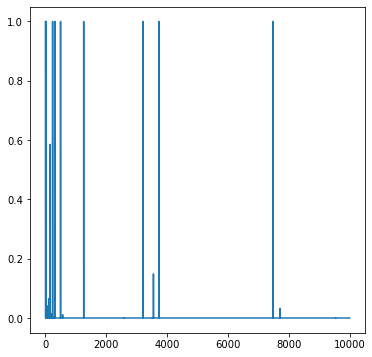

In [851]:
N_samples_x = 10001
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)
print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)


In [852]:
logPi(x, z, y, sigma, alpha)


DeviceArray(451.7538912, dtype=float64)

In [853]:
logPi(jnp.array([x[0],x[1]]), z, y, sigma, alpha)

DeviceArray(451.7538912, dtype=float64)

In [854]:
logPi(jnp.array([x[1],x[1]]), z, y, sigma, alpha)

DeviceArray(438.5384653, dtype=float64)

In [855]:
z_rec

DeviceArray([1, 0, 0, 1, 1, 2, 1, 2, 0, 0, 1, 2, 1, 1, 2, 1, 0, 2, 2, 2,
             1, 0, 2, 1, 0, 1, 0, 2, 0, 1, 0, 1, 2, 1, 1, 2, 2, 2, 2, 2,
             1, 0, 0, 1, 1, 1, 2, 1, 0, 1, 2, 1, 2, 2, 1, 0, 1, 2, 2, 0,
             0, 1, 2, 1, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1,
             2, 0, 0, 1, 2, 0, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 2, 0,
             0, 1, 2, 1, 0, 2, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 2, 0, 1, 0,
             1, 2, 1, 1, 2, 2, 1, 0, 1, 1, 1, 0, 0, 2, 2, 1, 1, 0, 1, 1,
             1, 1, 1, 0, 2, 2, 1, 0, 2, 1, 2, 0, 1, 2, 0, 1, 1, 2, 2, 2,
             1, 2, 1, 2, 0, 1, 2, 0, 1, 0, 0, 2, 0, 2, 1, 2, 1, 1, 0, 0,
             0, 1, 1, 1, 1, 2, 1, 1, 2, 0, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1,
             2, 0, 2, 2, 0, 1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 2,
             0, 2, 0, 1, 0, 1, 2, 0, 2, 2, 2, 0, 1, 2, 1, 1, 0, 1, 1, 1,
             0, 0, 0, 0, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1,
             0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 2, 2, 0,

In [856]:
myf = lambda x0, x1 : logPi(jnp.array([x0, x1]), z0, y, sigma, alpha)
xx = jnp.linspace(-3,3,1000)    
yy = jnp.linspace(-3,3,1000)

In [863]:
myf_x = lambda x : jax.vmap(myf, in_axes = (None, 0))(x, yy)
myf_xy0 = jax.vmap(myf_x)(xx)

TypeError: mul got incompatible shapes for broadcasting: (1000, 1000, 100), (1000, 1000, 1000).

In [ ]:
plt.imshow((myf_xy1)); plt.colorbar()

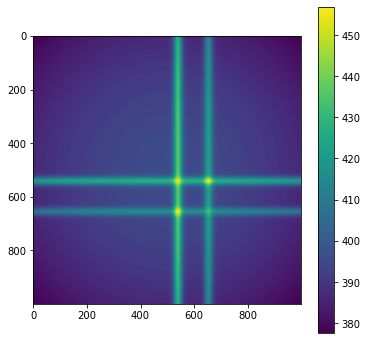

In [ ]:
plt.imshow((myf_xy0)); plt.colorbar()

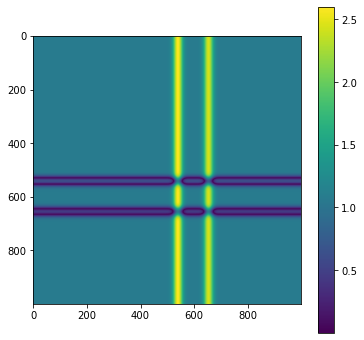

In [ ]:
plt.imshow(jnp.abs(myf_xy0-myf_xy2)); plt.colorbar()

In [ ]:
print(myf(x[0], x[1]))
print(myf(x[0], x[0]))
print(myf(x[1], x[1]))
print(myf(x[1], x[0]))

### Now sample z

In [ ]:
N_samples_z = 100001
z0 = jnp.array(np.random.randint(0, K, (N,)))
B = 3

params_z = {"x" : x_sample[N_samples_x-2], "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K}

key, subkey = random.split(key)
z_mean, z_r, z_samples = mcmc(subkey, proposal_z, z0, N_samples_z, params_z, 1, 1)
z_rec = z_samples[N_samples_z-2]

plt.plot(z_r)
print(jnp.sum(jnp.abs(z0-z))/N)
print(jnp.sum(jnp.abs(z_rec-z))/N)


  MCMC sample 1000, loss = 450.2117896034937, a = 0.9513309924854216
  MCMC sample 2000, loss = 450.2103177797578, a = 0.719135935871051
  MCMC sample 3000, loss = 452.62943592013437, a = 0.15899757835680953
  MCMC sample 4000, loss = 454.36821304883, a = 0.015317575013905996
  MCMC sample 5000, loss = 450.85048950213513, a = 0.35091889295690665
  MCMC sample 6000, loss = 450.2266886792023, a = 1.0
  MCMC sample 7000, loss = 450.223275332105, a = 0.7562855466090286
  MCMC sample 8000, loss = 451.4951666434448, a = 0.2731047812113359
  MCMC sample 9000, loss = 450.31321557488684, a = 0.34853772964818286
  MCMC sample 10000, loss = 450.4897152551872, a = 0.05650441486719958
  MCMC sample 11000, loss = 450.32393325440967, a = 0.9841278694721944
  MCMC sample 12000, loss = 450.26978598461295, a = 0.6039901869116622
  MCMC sample 13000, loss = 450.82128588613125, a = 1.0
  MCMC sample 14000, loss = 450.3142280417344, a = 1.0
  MCMC sample 15000, loss = 450.149718428488, a = 0.59720213136079

In [ ]:
plt.plot(jnp.abs(z0-z), '.')


In [ ]:
plt.plot(jnp.abs(z_rec-z), '.')

In [868]:
z

DeviceArray([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
             0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
             1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
             1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
             1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0],            dtype=int64)

In [869]:
z_rec

DeviceArray([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
             0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
             0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
             1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1],            dtype=int64)

In [ ]:
n_samples_z

In [ ]:
z_est = jnp.mean(z_samples, axis=0)

In [ ]:
plt.plot(jnp.abs(z_est-z), '.')

In [ ]:
logPi(x, z, y, sigma, alpha)

In [ ]:
logPi(x, z0, y, sigma, alpha)